In [1]:
import sympy
from mira.metamodel import *
from mira.modeling.viz import GraphicalModel

In [2]:
species = lambda: Concept(name='x')

In [3]:
intrinsic = NaturalReplication(subject=species())
intrinsic.set_mass_action_rate_law('r')

interaction = ControlledReplication(controller=species(),
                                    subject=species())
interaction.set_mass_action_rate_law('a')

initial = Initial(concept=species(), expression=sympy.Float(1))
params = {'r': Parameter(name='r', value=1), 'a': Parameter(name='a', value=1)}

In [4]:
tm = TemplateModel(templates=[intrinsic, interaction],
                   initials={'x': initial},
                   parameters=params)

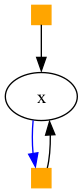

In [5]:
GraphicalModel.for_jupyter(tm)

In [6]:
tm_strat = stratify(tm, key='species', strata=['1', '2', '3', '4'],
                    structure=[], cartesian_control=True)

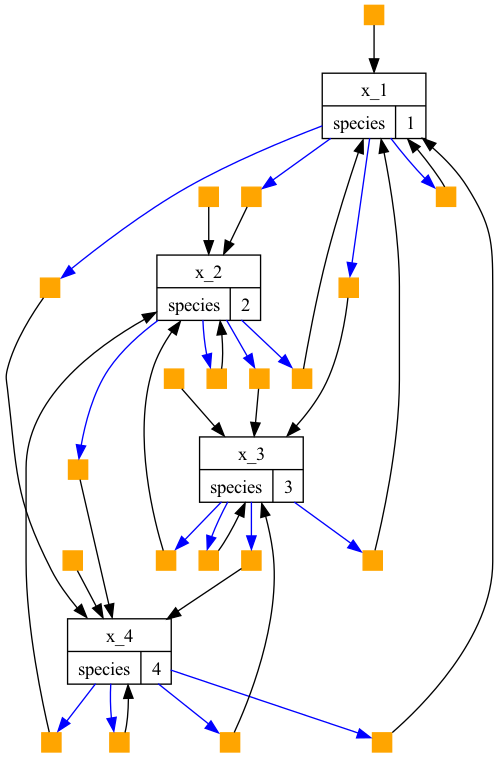

In [7]:
GraphicalModel.for_jupyter(tm_strat)

In [8]:
r_i = [0.53, 0.42, 0.49, 0.33]
x0_i = [0.51, 0.39, 0.88, 0.4]
a_ij = [
    [  -0.5, - 0.01, 0.002, -0.009],
    [     0,   -0.5,     0, -0.169],
    [-0.002, -0.003,  -0.5,   0.02],
    [     0, -0.226, -0.04,   -0.5]
]

In [9]:
def get_interactor_species(template):
    ints = template.get_interactors()
    return [int(i.context['species']) for i in ints]

for template in tm_strat.templates:
    ints = get_interactor_species(template)
    param = list(template.get_parameter_names())[0]
    if param.startswith('r'):
        tm_strat.parameters[param].value = r_i[ints[0]-1]
    else:
        tm_strat.parameters[param].value = a_ij[ints[1]-1][ints[0]-1]
        

In [10]:
from mira.modeling.ode import OdeModel, simulate_ode_model
from mira.modeling import Model
import numpy
import matplotlib.pyplot as plt

In [11]:
om = OdeModel(Model(tm_strat), initialized=True)

In [12]:
res = simulate_ode_model(om, times=numpy.linspace(0, 30, 100))

In [13]:
om.kinetics

Matrix([
[-0.5*y[0, 0]**2 - 0.01*y[0, 0]*y[1, 0] + 0.002*y[0, 0]*y[2, 0] - 0.009*y[0, 0]*y[3, 0] + 0.53*y[0, 0]],
[                                               -0.5*y[1, 0]**2 - 0.169*y[1, 0]*y[3, 0] + 0.42*y[1, 0]],
[-0.002*y[0, 0]*y[2, 0] - 0.003*y[1, 0]*y[2, 0] - 0.5*y[2, 0]**2 + 0.02*y[2, 0]*y[3, 0] + 0.49*y[2, 0]],
[                        -0.226*y[1, 0]*y[3, 0] - 0.04*y[2, 0]*y[3, 0] - 0.5*y[3, 0]**2 + 0.33*y[3, 0]]])

(0.0, 1.2)

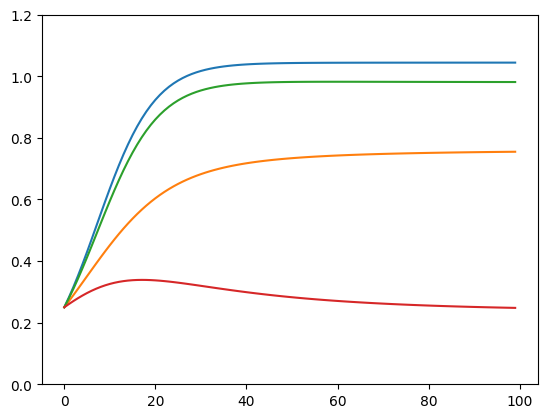

In [14]:
plt.plot(res)
plt.ylim([0, 1.2])

In [15]:
from mira.modeling.amr.regnet import template_model_to_regnet_json

In [16]:
regnet_json = template_model_to_regnet_json(tm_strat)

In [17]:
with open('scenario4_1.json', 'w') as fh:
    json.dumps(regnet_json, indent=1)